## BIOENG-310: Neuroscience Foundations for Engineers

Notebook created by Martin Schrimpf.

# Week 5: Data visualization and linear probing

### Load Data

At the current state, it can unfortunately often be difficult to access brain recordings. Not all groups share their data (although new federal mandates are improving this), and even if the data is accessible it is often difficult to interact with due to non-standard file formats, missing/unclear metadata, and obscure processing pipelines.

That being said, we will here save you the headache by starting from a packaged and standardized dataset.
This data was first published by [Freeman* & Ziemba* et al. 2013](https://www.nature.com/articles/nn.3402) and subsequently packaged into the [Brain-Score](www.brain-score.org) platform.
The format of the data here is in [xarray](https://xarray.dev), a structure allowing for multi-dimensional data with multiple metadata along all dimensions. If you know pandas, xarray is the multi-dimensional extension of it.

To load the data, make sure you have all dependencies installed (see `requirements.txt`).

In [36]:
import brainscore_vision

data = brainscore_vision.load_dataset('FreemanZiemba2013.public')
print(data)

<xarray.NeuronRecordingAssembly 'movshon.FreemanZiemba2013.public' (
                                                                    neuroid: 205,
                                                                    time_bin: 300,
                                                                    presentation: 2700)>
dask.array<open_dataset-c5e986661c766caeaf9450ff9a0e8b00movshon.FreemanZiemba2013.public, shape=(205, 300, 2700), dtype=float64, chunksize=(205, 300, 2700), chunktype=numpy.ndarray>
Coordinates:
  * neuroid                    (neuroid) MultiIndex
  - neuroid_id                 (neuroid) int64 1 2 3 4 5 ... 201 202 203 204 205
  - region                     (neuroid) object 'V1' 'V1' 'V1' ... 'V2' 'V2'
  * time_bin                   (time_bin) MultiIndex
  - time_bin_start             (time_bin) int64 0 1 2 3 4 ... 296 297 298 299
  - time_bin_end               (time_bin) int64 1 2 3 4 5 ... 297 298 299 300
  * presentation               (presentation) MultiIndex
  - re

### Stimuli

How did this data come about in the first place? Primate subjects were presented with images while experimenters were recording from early visual cortex.

What are those images? 

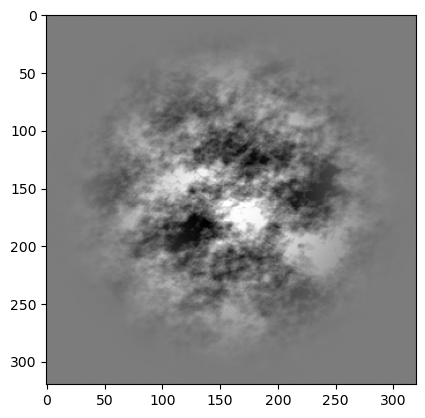

In [33]:
%matplotlib inline
from matplotlib import pyplot, image

stimuli = data.stimulus_set
single_stimulus_id = stimuli['stimulus_id'].values[0]
image_path = stimuli.get_stimulus(single_stimulus_id)
image_content = image.imread(image_path)
pyplot.imshow(image_content, cmap='gray')

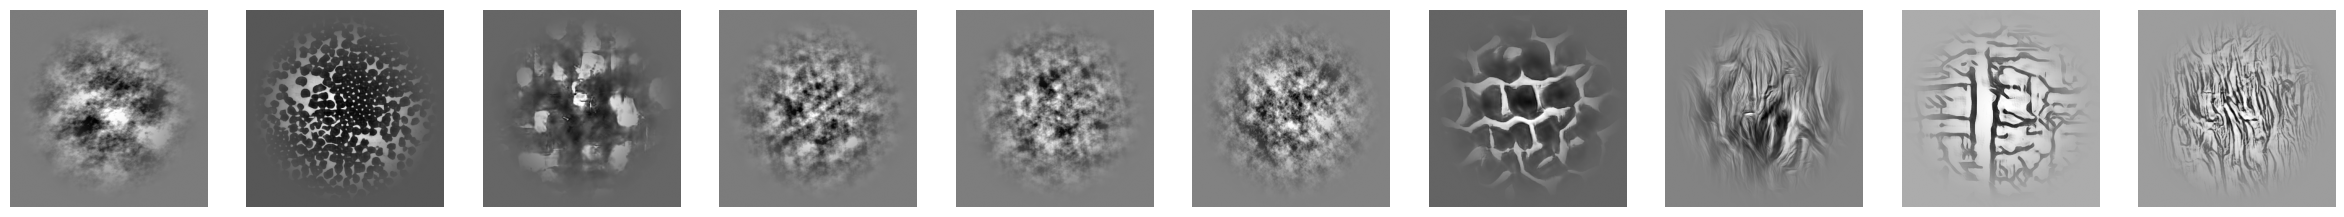

In [34]:
# Let's look at some more stimuli.
fig, axes = pyplot.subplots(nrows=1, ncols=10, figsize=(30, 3))
for i, ax in enumerate(axes.flatten()):
    current_stimulus_id = stimuli['stimulus_id'].values[i]
    image_path = stimuli.get_stimulus(current_stimulus_id)
    image_content = image.imread(image_path)
    ax.imshow(image_content, cmap='gray')
    ax.set_axis_off()

### Data visualization

Now that we saw what kinds of images the experiment was run with, let's see what kind of data came out of it. It's always a good idea to first plot your raw data before any fancy analysis to make sure it is what you expect.

Let's start with the response to the single stimulus that we visualized at first before.

In [37]:
single_stimulus_id = stimuli['stimulus_id'].values[0]
stimulus_data = data.sel(stimulus_id=single_stimulus_id)
print(stimulus_data)

<xarray.NeuronRecordingAssembly 'movshon.FreemanZiemba2013.public' (
                                                                    neuroid: 205,
                                                                    time_bin: 300,
                                                                    presentation: 20)>
dask.array<getitem, shape=(205, 300, 20), dtype=float64, chunksize=(205, 300, 20), chunktype=numpy.ndarray>
Coordinates:
  * neuroid                    (neuroid) MultiIndex
  - neuroid_id                 (neuroid) int64 1 2 3 4 5 ... 201 202 203 204 205
  - region                     (neuroid) object 'V1' 'V1' 'V1' ... 'V2' 'V2'
  * time_bin                   (time_bin) MultiIndex
  - time_bin_start             (time_bin) int64 0 1 2 3 4 ... 296 297 298 299
  - time_bin_end               (time_bin) int64 1 2 3 4 5 ... 297 298 299 300
  * presentation               (presentation) MultiIndex
  - repetition                 (presentation) int64 0 1 2 3 4 ... 15 16 17 18 19
 

We see that this stimulus was shown a total of 20 times, has 205 neural sites recorded, and was collected over 300 time-bins (in this case 1 ms each).
In visual neuroscience, repeated trials are typically done to be able to average out the noise, so let's do exactly that by averaging over all repetitions.

In [39]:
from brainscore_vision.benchmark_helpers.neural_common import average_repetition
stimulus_data = average_repetition(stimulus_data)  # average over repeated repetitions of the same stimulus
stimulus_data = stimulus_data.squeeze('presentation')
print(stimulus_data)

<xarray.NeuronRecordingAssembly 'movshon.FreemanZiemba2013.public' (
                                                                    neuroid: 205,
                                                                    time_bin: 300)>
dask.array<getitem, shape=(205, 300), dtype=float64, chunksize=(205, 300), chunktype=numpy.ndarray>
Coordinates:
  * neuroid         (neuroid) MultiIndex
  - neuroid_id      (neuroid) int64 1 2 3 4 5 6 7 ... 200 201 202 203 204 205
  - region          (neuroid) object 'V1' 'V1' 'V1' 'V1' ... 'V2' 'V2' 'V2' 'V2'
  * time_bin        (time_bin) MultiIndex
  - time_bin_start  (time_bin) int64 0 1 2 3 4 5 6 ... 294 295 296 297 298 299
  - time_bin_end    (time_bin) int64 1 2 3 4 5 6 7 ... 295 296 297 298 299 300
    presentation    object ('21041db1f26c142812a66277c2957fb3e2070916', 5, 'n...
Attributes:
    stimulus_set_identifier:  FreemanZiemba2013.aperture-public
    stimulus_set:                                                  image_id  ...
    identifier

Now we can visualize the actual recordings for this stimulus:

Text(0, 0.5, 'Neural site (#)')

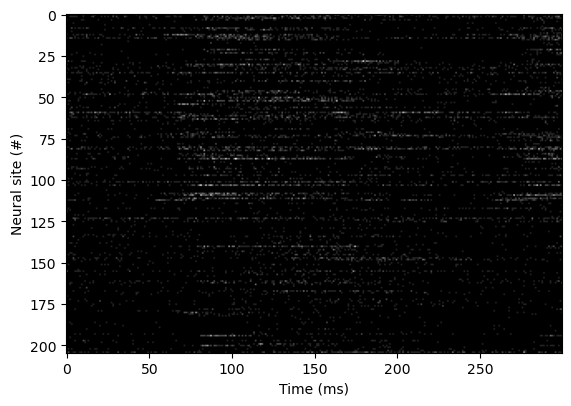

In [42]:
fig, ax = pyplot.subplots()
ax.imshow(stimulus_data.values, cmap='gray')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Neural site (#)')

Cool! Lots of activity

In [ ]:
from brainscore_vision.benchmark_helpers.neural_common import average_repetition

def filter_data(data):
    data = data.sel(region='V1')  # use only V1 (easy select via metadata :))
    data = data.sel(time_bin_start=100)  # use only a single time-bin
    data = average_repetition(data)  # average over repeated repetitions of the same stimulus
    return data
    
data = filter_data(data)
print(data)